In [1]:
from seaborn import histplot, barplot
%load_ext autoreload
%autoreload 2

In [66]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import torch
from collections import Counter

from embedding import load_embeddings_safetensors, read_fasta, read_tsv

sns.set_style('darkgrid')

# Baseline Models and Dataset exploration

## Data loading

In [3]:
# make sure both dataset are from the same model

POST_TRAINING_SEQUENCE_FILE = "data/newly_discovered_dissimilar_proteins_2024.fasta"
POST_TRAINING_EMBEDDING_FILE = "outputs/embeddings/esm2-facebook/embedding-newly-discovered-35M-avg.safetensors"

PRE_TRAINING_SEQUENCE_FILE = "data/uniref50_100000.tsv"
PRE_TRAINING_EMBEDDING_FILE = "outputs/embeddings/esm2-facebook/embedding-uniref50-random-35M-avg.safetensors"

In [67]:
PRE_TRAINING_SIZE = 1237

pre_training_embeddings, pre_training_ids = load_embeddings_safetensors(PRE_TRAINING_EMBEDDING_FILE)
pre_training_idx = random.sample(list(range(len(pre_training_embeddings))), PRE_TRAINING_SIZE)

pre_training_embeddings = pre_training_embeddings[pre_training_idx]
pre_training_ids = [pre_training_ids[i] for i in pre_training_idx]

print(len(pre_training_embeddings))

post_training_embeddings, post_training_ids = load_embeddings_safetensors(POST_TRAINING_EMBEDDING_FILE)
print(len(post_training_embeddings))

1237
1237


In [68]:
pre_training_ids_seq = read_tsv(PRE_TRAINING_SEQUENCE_FILE)
post_training_ids_seq = read_fasta(POST_TRAINING_SEQUENCE_FILE)

id_to_seq_mapping = {k: v for k, v in (pre_training_ids_seq + post_training_ids_seq)}

In [69]:
# 0 means membership, 1 new sample

dataset = [(emb, 0) for emb in pre_training_embeddings] + [(emb, 1) for emb in post_training_embeddings]
len(dataset)

2474

## Dataset exploration

In [70]:
pre_training_lens = [len(id_to_seq_mapping[k]) for k in pre_training_ids if len(id_to_seq_mapping[k]) < 5000]
post_training_lens = [len(id_to_seq_mapping[k]) for k in post_training_ids if len(id_to_seq_mapping[k]) < 5000]

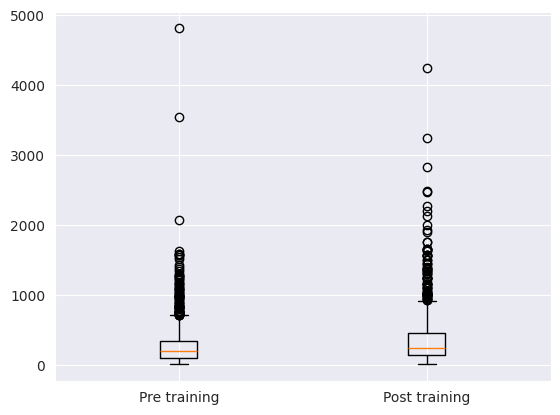

In [71]:
plt.boxplot([pre_training_lens, post_training_lens], tick_labels=['Pre training', 'Post training'])
plt.show()

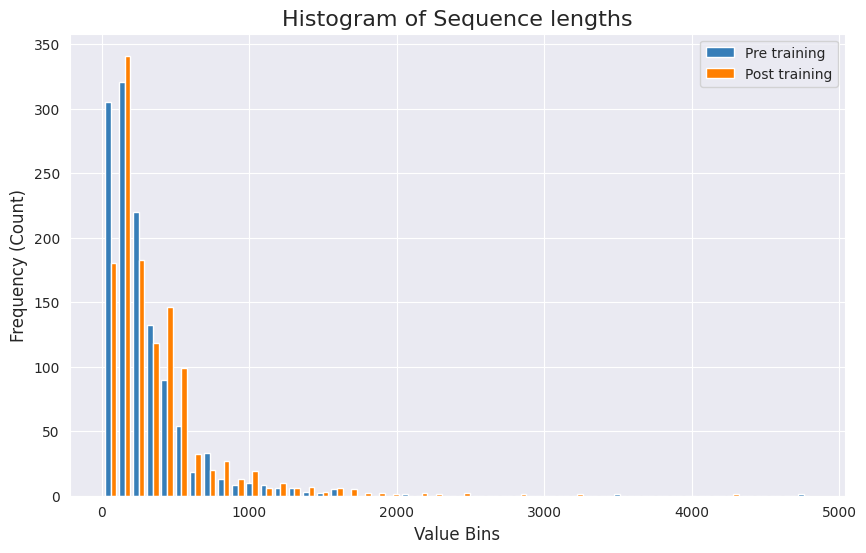

In [72]:
num_bins = 50
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability

plt.hist([pre_training_lens, post_training_lens], bins=num_bins, label=['Pre training', 'Post training'], color=['#377eb8', '#ff7f00'])

# --- 3. Add Labels and Title for Clarity ---
plt.title('Histogram of Sequence lengths', fontsize=16)
plt.xlabel('Value Bins', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)
plt.legend()
plt.show()

In [80]:
pre_training_freq = Counter(c for c in "".join(id_to_seq_mapping[k] for k in pre_training_ids))
post_training_freq = Counter(c for c in "".join(id_to_seq_mapping[k] for k in post_training_ids))

all_chars = sorted(list(set(pre_training_freq.keys()) | set(post_training_freq.keys())))

freq1 = [pre_training_freq.get(char, 0) for char in all_chars]
freq2 = [post_training_freq.get(char, 0) for char in all_chars]

In [82]:
len("".join(id_to_seq_mapping[k] for k in pre_training_ids)), len("".join(id_to_seq_mapping[k] for k in post_training_ids))

(351859, 474378)

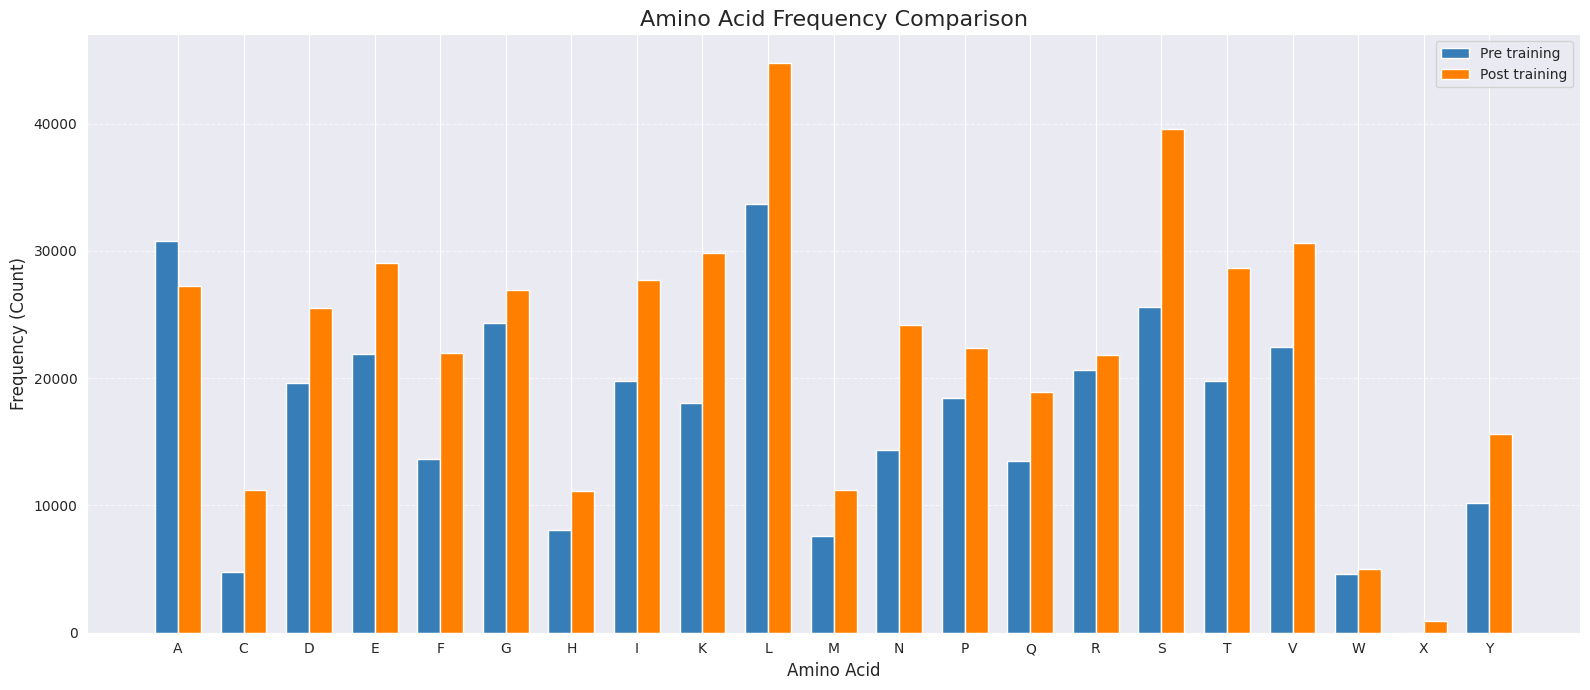

In [81]:
x = np.arange(len(all_chars))

bar_width = 0.35
fig, ax = plt.subplots(figsize=(16, 7)) # A wider figure is better for many characters

# Plot the bars for the first list
bars1 = ax.bar(x - bar_width/2, freq1, bar_width, label='Pre training', color='#377eb8')

# Plot the bars for the second list, shifted to the right
bars2 = ax.bar(x + bar_width/2, freq2, bar_width, label='Post training', color='#ff7f00')

ax.set_title('Amino Acid Frequency Comparison', fontsize=16)
ax.set_ylabel('Frequency (Count)', fontsize=12)
ax.set_xlabel('Amino Acid', fontsize=12)

# Set the x-tick positions and labels
ax.set_xticks(x)
ax.set_xticklabels(all_chars)

ax.legend() # Display the legend
ax.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid

fig.tight_layout()
plt.show()

In [94]:
torch.std_mean(torch.linalg.vector_norm(pre_training_embeddings, dim=1)), torch.std_mean(torch.linalg.vector_norm(post_training_embeddings, dim=1))

((tensor(0.8469), tensor(6.0224)), (tensor(0.8130), tensor(5.8061)))

## Dimensionality reduction

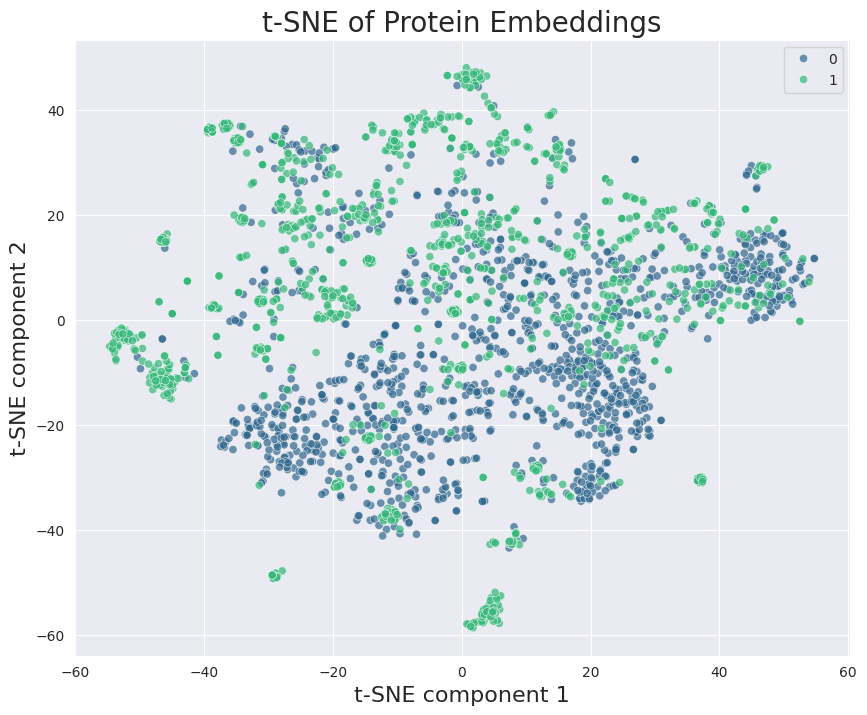

In [52]:
tsne_reducer = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embeddings = tsne_reducer.fit_transform(torch.stack([x[0] for x in dataset]))

labels = [x[1] for x in dataset]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1],
    palette='viridis', hue=labels, alpha=0.7
)
plt.title('t-SNE of Protein Embeddings', size=20)
plt.xlabel('t-SNE component 1', size=16)
plt.ylabel('t-SNE component 2', size=16)
plt.show()

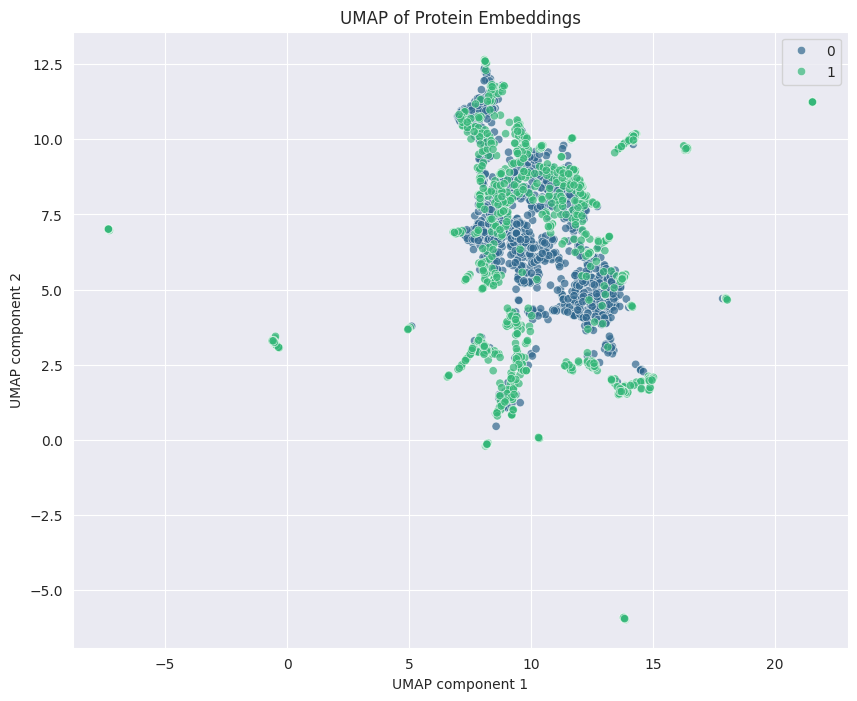

In [101]:
import umap

umap_reducer = umap.UMAP(n_components=2, n_neighbors=20, metric="euclidean")
umap_embeddings = umap_reducer.fit_transform(torch.stack([x[0] for x in dataset]))

labels = [x[1] for x in dataset]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=umap_embeddings[:, 0], y=umap_embeddings[:, 1],
    palette='viridis', hue=labels, alpha=0.7
)
plt.title('UMAP of Protein Embeddings')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.show()

## kNN

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

X_np = torch.stack([x[0] for x in dataset]).cpu().numpy()
y_np = np.array([x[1] for x in dataset])

# --- 3. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.3, random_state=42, stratify=y_np
)
print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# --- 4. (Optional but Recommended) Scale the Features ---
# k-NN is distance-based, so it's sensitive to the scale of features.
# Even though embeddings are often in a similar range, scaling is good practice.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training set size: 1731
Testing set size: 743


In [99]:
# --- 5. Create and Train the k-NN Classifier ---
# Let's choose k=5. 'n_neighbors' is the 'k'.
k = 5

# By default, the metric is 'minkowski' with p=2, which is the Euclidean distance.
# For high-dimensional data like embeddings, 'cosine' distance is often better.
# We will create two models to compare.

# Model 1: Using Euclidean Distance
knn_euclidean = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
# For k-NN, "fitting" is just storing the training data in memory.
knn_euclidean.fit(X_train_scaled, y_train)

# Model 2: Using Cosine Distance
knn_cosine = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn_cosine.fit(X_train_scaled, y_train)


# --- 6. Make Predictions on the Test Set ---
y_pred_euclidean = knn_euclidean.predict(X_test_scaled)
y_pred_cosine = knn_cosine.predict(X_test_scaled)

# --- 7. Evaluate the Models ---
accuracy_euclidean = accuracy_score(y_test, y_pred_euclidean)
accuracy_cosine = accuracy_score(y_test, y_pred_cosine)

print(f"\nAccuracy with Euclidean distance: {accuracy_euclidean:.4f}")
print("Classification Report (Euclidean):")
print(classification_report(y_test, y_pred_euclidean))

print(f"\nAccuracy with Cosine distance: {accuracy_cosine:.4f}")
print("Classification Report (Cosine):")
print(classification_report(y_test, y_pred_cosine))


Accuracy with Euclidean distance: 0.8560
Classification Report (Euclidean):
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       372
           1       0.84      0.88      0.86       371

    accuracy                           0.86       743
   macro avg       0.86      0.86      0.86       743
weighted avg       0.86      0.86      0.86       743


Accuracy with Cosine distance: 0.8479
Classification Report (Cosine):
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       372
           1       0.85      0.85      0.85       371

    accuracy                           0.85       743
   macro avg       0.85      0.85      0.85       743
weighted avg       0.85      0.85      0.85       743

